# GAT

Velickovic et al. (2017) introduced a novel neural network architecture, known as the graph attention network (GAT), for processing graph-structured data. GATs overcome the limitations of previous graph convolution-based methods by utilizing masked self-attentional layers. Through layer stacking, nodes are empowered to attend to the features of their neighborhoods, allowing for the implicit assignment of varying weights to different nodes without the need for expensive matrix operations or prior knowledge of the graph structure. Given an input graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ and a set of node features $\textbf{X} \in \mathbb{R}^{d \times |\mathcal{V}|}$, Velickovic et al. (2017) describe their graph attention mechanism as follows.

$$
\alpha_{un} = \frac{
\text{exp} \left( \text{LeakyReLu} \left( \vec{\textbf{a}}^\textbf{T} \left[ \textbf{W}_u || \textbf{W}_n \right] \right) \right)
}{
\sum_{v\in \mathcal{N}(u)} \text{exp} \left( \text{LeakyReLu} \left( \vec{\textbf{a}}^\textbf{T} \left[ \textbf{W}_u || \textbf{W}_v \right] \right) \right) }
$$

where

- for each node $u \in \mathcal{V}$, $v \in \mathcal{N}(u)$ and $\mathcal{N}(u)$ is the set of neighbourhood nodes of $u$
- $\alpha_{un}$ is the attention coefficient that indicates the importance of node $n$'s features to node $u$
- LeakyReLu is the activation function
- $.^T$ represents transposition
- $||$ is the concatenation operator
- $\vec{\textbf{a}}$ is a weight vector that parameterise the attention mechanism $a$, where $a$ can be a neural network

The graph structure is injected into the mechanism by performing *masked attention*, which computes $a ( \textbf{W}_u, \textbf{W}_v )$ for nodes $v \in \mathcal{N}(u) $. The normalized attention coefficients are employed to compute a linear combination of the corresponding features, thereby producing the final output features for each node. To enhance the learning process of self-attention, a multi-head attention mechanism is utilized.

$$
u' = \text{\LARGE $||$}^M_{m=1} \sigma \left( \sum_{v \in \mathcal{N}(u)} \alpha_{uv}^{(m)} \textbf{W}^{(m)}_v \right)
$$

where

- $\sigma$ is the potential nonlinearity
- $M$ is the number of independent attention mechanisms to execute
- $\alpha_{uv}^{(m)}$ are normalized attention coefficients computed by the $m^{\text{th}}$ attention mechanism $a^{(m)}$ and $W^{(m)}$ is the corresponding input linear transformation's weight matrix.

In [1]:
import math
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
from model.dgl.GAT import GAT
from sklearn.metrics import mean_squared_error, r2_score
from data.featurization.dgl_Graph import DGL_Graph
from model.dgl.DGLModel import DGLModel
from model.abstractmodel import AbstractModel
from ray import tune
import pandas as pd
import torch

In [3]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST = Dataset.load_csv("ds/TST")

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [5]:
RANDOM_STATE = 1234
SPACE = {
    "hidden_feats": tune.choice([[64], [64, 64], [64, 64, 64], [64, 128], [64, 128, 256]]),
    "num_heads": tune.randint(2, 6),
    "feat_drops": tune.uniform(0, 1),
    "attn_drops": tune.uniform(0, 1),
    "alphas": tune.uniform(0, 1),
    "residuals": tune.choice([True, False]),
    "agg_modes": tune.choice(["flatten", "mean"]),
    "biases": tune.choice([True, False]),
    "lr": tune.choice([0.1, 0.01, 0.001]),
    "weight_decay": tune.uniform(0, 1),
    "epoch": tune.choice([100, 150, 200, 250, 300]),
}

In [6]:
def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    model = GAT(
        task_type="regression",
        # GAT Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=config["hidden_feats"],
        num_heads=config["num_heads"],
        feat_drops=config["feat_drops"],
        attn_drops=config["attn_drops"],
        alphas=config["alphas"],
        residuals=config["residuals"],
        agg_modes=config["agg_modes"],
        biases=config["biases"],
        # classifier_hidden_feats=128,
        # classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=config["lr"],
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=4096,
        verbose=False
    )
    scores = model.fit(trn, val=val, epochs=config["epoch"], verbose=False)
    tune.report(rmse=scores["rmse"][-1])

In [7]:
from ray.tune.search import BasicVariantGenerator

tuner = DGLModel.tuner(
    trainable_func,
    SPACE,
    num_samples=50,
    search_alg=BasicVariantGenerator(max_concurrent=10),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-24 18:47:54,482	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-03-24 18:48:00,077	WARNING tune.py:146 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 

KeyboardInterrupt



In [ ]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

In [ ]:
MODEL = GAT(
    task_type="regression",
    # GAT Configuration
    n_tasks=1,
    in_feats=featurizer.get_node_feat_size(),
    hidden_feats=[64],
    num_heads=5,
    feat_drops=0.2023595030995624,
    attn_drops=0.26105451494398646,
    alphas=0.5288055588532301,
    residuals=True,
    agg_modes="flatten",
    biases=True,
    classifier_hidden_feats=128,
    classifier_dropout=0,
    predictor_hidden_feats=128,
    predictor_dropout=0,
    # Abstract DGL Configuration
    lr=0.001,
    y_name="LogS exp (mol/L)",
    weight_decay=0,
    batch_size=4096
)
trn, val = TRN.split()
scores = MODEL.fit(trn, val=val, epochs=250)

In [ ]:
pd.DataFrame({
    "loss": [v.item() for v in MODEL.scores["loss"]],
    "rmse": [v.item() for v in MODEL.scores["rmse"]]
}).plot()

In [ ]:
result = MODEL.cross_validate(
    dataset=TRN,
    epochs=best_result.config["epoch"],
    extra_eval_set=TST,
    cv=5,
    verbose=True
)

In [ ]:
print(f"TST : RMSE {mean_squared_error(TST.y, MODEL.predict(TST).cpu(), squared=False)}")

In [ ]:
SPACE = {
    "num_heads": tune.uniform(4, 8),
    "feat_drops": tune.uniform(0, 0.4),
    "attn_drops": tune.uniform(0, 0.4),
    "alphas": tune.uniform(0, 1),
    "weight_decay": tune.uniform(0, 1),
    "epoch": tune.uniform(200, 400),
}

In [ ]:
def trainable_func(config: dict, dataset: Dataset):
    trn, val = dataset.split()
    model = GAT(
        task_type="regression",
        # GAT Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 64],
        num_heads=int(config["num_heads"]),
        feat_drops=config["feat_drops"],
        attn_drops=config["attn_drops"],
        alphas=config["alphas"],
        residuals=True,
        agg_modes="flatten",
        biases=True,
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=4096,
        verbose=False
    )
    scores = model.fit(trn, val=val, epochs=int(config["epoch"]), verbose=False)
    tune.report(rmse=scores["rmse"][-1])

In [ ]:
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search import ConcurrencyLimiter

tuner = DGLModel.tuner(
    trainable_func,
    space=SPACE,
    num_samples=50,
    search_alg=ConcurrencyLimiter(BayesOptSearch(metric="rmse", mode="min"), max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

In [8]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST = Dataset.load_csv("ds/TST")

In [9]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [10]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [11]:
num_heads = 5
AbstractModel.set_seed(2387)

k_pred_tst1 = []

for trn, val in zip(trn_sets, val_sets):
    model = GAT(
        task_type="regression",
        # GAT Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 64 * num_heads],
        num_heads=num_heads,
        feat_drops=0,
        attn_drops=0,
        alphas=0,
        residuals=True,
        agg_modes="flatten",
        biases=True,
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0,
        batch_size=4096,
    )
    model.fit(trn, val=val, epochs=400, min_epoch=300, early_stop=20)

    k_pred_tst1.append(model.predict(TST).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 82%|████████▏ | 326/400 [00:39<00:08,  8.31it/s, loss: 0.005 rmse: 1.081]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 86%|████████▋ | 345/400 [00:27<00:04, 12.63it/s, loss: 0.005 rmse: 0.710]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 81%|████████  | 323/400 [00:27<00:06, 11.88it/s, loss: 0.015 rmse: 0.721]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 84%|████████▍ | 335/400 [00:23<00:04, 14.18it/s, loss: 0.004 rmse: 1.127]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 82%|████████▏ | 327/400 [00:22<00:05, 14.56it/s, loss: 0.003 rmse: 0.712]


In [12]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]

In [13]:
print(f"TST : RMSE {mean_squared_error(TST.y, pred_tst1, squared=False)}")
print(f"TST : R^2 {r2_score(TST.y, pred_tst1)}")

TST : RMSE 0.8575179825352407
TST : R^2 0.6008285817277461


Text(0.5, 1.0, '2008 Solubility Challenge Test Set (GAT)\nRMSE: 0.858, $R^2$: 0.601')

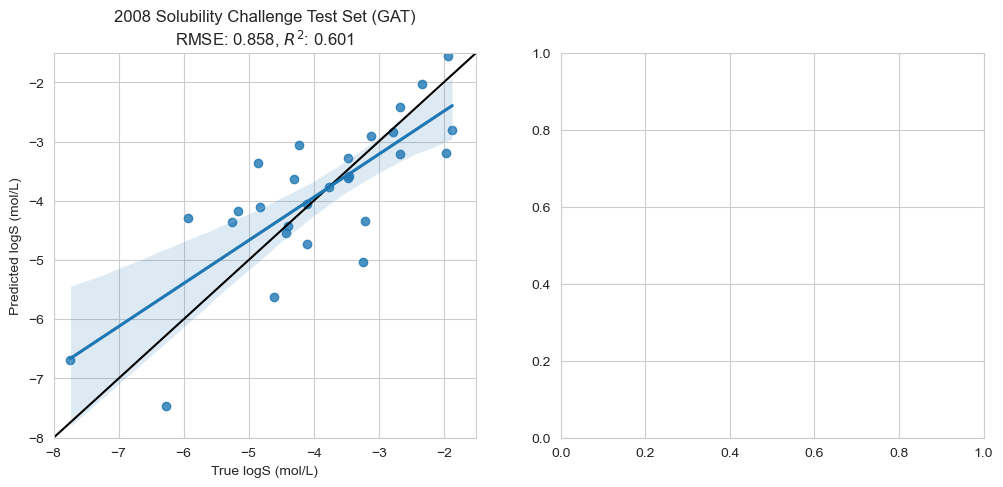

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "GAT"
min_ax1, max_ax1 = -8, -1.5

fig, (ax1, _) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)

ax1.set_title(f"2008 Solubility Challenge Test Set ({model_name})\n"
              f"RMSE: {mean_squared_error(TST.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST.y, pred_tst1):.3f}")

In [15]:
TRN = Dataset.load_csv("ds/08SC/TRN")
TST = Dataset.load_csv("ds/TST")

In [16]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [17]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [18]:
num_heads = 5
AbstractModel.set_seed(2387)

k_pred_tst1 = []

for trn, val in zip(trn_sets, val_sets):
    model = GAT(
        task_type="regression",
        # GAT Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 64 * num_heads],
        num_heads=num_heads,
        feat_drops=0,
        attn_drops=0,
        alphas=0,
        residuals=True,
        agg_modes="flatten",
        biases=True,
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0,
        batch_size=4096,
    )
    model.fit(trn, val=val, epochs=400, min_epoch=300, early_stop=20)

    k_pred_tst1.append(model.predict(TST).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 82%|████████▏ | 329/400 [00:12<00:02, 27.29it/s, loss: 0.000 rmse: 1.983] 


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 81%|████████  | 324/400 [00:11<00:02, 27.61it/s, loss: 0.000 rmse: 1.345]  


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 84%|████████▍ | 336/400 [00:13<00:02, 24.64it/s, loss: 0.000 rmse: 0.847]  


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 83%|████████▎ | 333/400 [00:15<00:03, 21.26it/s, loss: 0.000 rmse: 0.947]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 81%|████████  | 323/400 [00:15<00:03, 21.33it/s, loss: 0.000 rmse: 1.415]


In [19]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]

In [20]:
print(f"TST : RMSE {mean_squared_error(TST.y, pred_tst1, squared=False)}")
print(f"TST : R^2 {r2_score(TST.y, pred_tst1)}")

TST : RMSE 0.984872441064748
TST : R^2 0.47345810155318613
